
# FastF1 + ML: Predicting F1 Lap Times from Session Data

**Goal:** Use the [FastF1](https://theoehrly.github.io/Fast-F1/) API to fetch a session's lap data, engineer features, and train a small ML model (Gradient Boosting) to **predict lap time**. We'll also explore **tyre wear effects** and produce publication‑ready plots.

**What this shows:**  
- Practical data acquisition from a motorsport API  
- Feature engineering with domain intuition (tyre compound, tyre life, stint structure, track temp)  
- Leakage‑aware validation using `GroupKFold` by driver  
- Model explainability via permutation importance  
- Clean, reproducible code you can run in < 1 day



## 1) Setup
Installs (first run only) and imports. We also enable on‑disk caching for FastF1.


In [1]:

# If running locally, uncomment the next line on first run:
# !pip install fastf1 scikit-learn matplotlib pandas numpy

import warnings, math
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import fastf1 as ff1
from fastf1.core import Laps

from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance

from pathlib import Path

# Enable cache
CACHE_DIR = Path("./.fastf1cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
ff1.Cache.enable_cache(str(CACHE_DIR))

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)



## 2) Choose an event and session
You can quickly switch `year`, `gp_name`, and `session_name`. FP2 is good for mixed‑pace long runs; Quali is great if you only want push laps.


In [2]:

# --- User Parameters (edit these) ---
year = 2024
gp_name = "British Grand Prix"  # Examples: "Bahrain Grand Prix", "Monaco Grand Prix", "British Grand Prix"
session_name = "R"            # Options: "FP1", "FP2", "FP3", "Q", "R", "SQ", "SSR" (sprint shootout), "SR" (sprint)
# ------------------------------------

session = ff1.get_session(year, gp_name, session_name)
session.load(laps=True, telemetry=False)  # telemetry per lap for all drivers is heavy; we stay at lap granularity for a 1-day project

laps = session.laps.copy()
laps.head(3)


core           INFO 	Loading data for British Grand Prix - Race [v3.6.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No ca

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:59:51.778000,HAM,44,0 days 00:01:36.034000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:37.703000,0 days 00:00:25.484000,NaT,0 days 00:59:26.446000,0 days 00:59:51.913000,299.0,257.0,244.0,299.0,False,MEDIUM,1.0,True,Mercedes,0 days 00:58:15.512000,NaT,1,2.0,False,,False,False
1,0 days 01:01:23.198000,HAM,44,0 days 00:01:31.420000,2.0,1.0,NaT,NaT,0 days 00:00:29.249000,0 days 00:00:37.314000,0 days 00:00:24.857000,0 days 01:00:21.055000,0 days 01:00:58.369000,0 days 01:01:23.226000,313.0,258.0,246.0,319.0,True,MEDIUM,2.0,True,Mercedes,0 days 00:59:51.778000,NaT,1,2.0,False,,False,True
2,0 days 01:02:54.914000,HAM,44,0 days 00:01:31.716000,3.0,1.0,NaT,NaT,0 days 00:00:29.287000,0 days 00:00:37.133000,0 days 00:00:25.296000,0 days 01:01:52.513000,0 days 01:02:29.646000,0 days 01:02:54.942000,307.0,257.0,246.0,294.0,False,MEDIUM,3.0,True,Mercedes,0 days 01:01:23.198000,NaT,1,2.0,False,,False,True



## 3) Clean & filter laps
We exclude in/out laps and laps under yellow/red/SC/VSC periods to make modelling more stable.  
We also convert `LapTime` from timedeltas to seconds.


In [3]:

def timedelta_to_seconds(td):
    if pd.isna(td):
        return np.nan
    return td.total_seconds()

# Keep only accurate green-flag laps (TrackStatus "1")
# TrackStatus can be like "1;2" etc during transitions; keep laps that include "1" and not serious flags.
def is_green_flag(ts):
    if pd.isna(ts):
        return True  # sometimes missing; keep
    ts = str(ts)
    # Consider green if it includes "1" and does not include "4"/"5" (SC/VSC) or "2"/"3" (Y/R flags)
    bad = any(x in ts for x in ["2", "3", "4", "5"])
    good = "1" in ts
    return good and not bad

df = laps[
    (~laps["PitOutTime"].notna())  # not an immediate pit-out lap
    & (~laps["PitInTime"].notna()) # not an immediate pit-in lap
    & (laps["LapTime"].notna())
    & (laps["IsAccurate"] == True)
].copy()

df = df[df["TrackStatus"].apply(is_green_flag)]

# Convert target to seconds
df["LapTime_s"] = df["LapTime"].apply(timedelta_to_seconds)

# Basic sanity filter: drop extreme lap times (box errors, traffic)
q1, q99 = df["LapTime_s"].quantile([0.01, 0.99])
df = df[(df["LapTime_s"] >= q1) & (df["LapTime_s"] <= q99)].copy()

df.shape, df[["Driver", "LapNumber", "Compound", "TyreLife", "TrackStatus", "LapTime_s"]].head(5)


((832, 32),
   Driver  LapNumber Compound  TyreLife TrackStatus  LapTime_s
 1    HAM        2.0   MEDIUM       2.0           1     91.420
 2    HAM        3.0   MEDIUM       3.0           1     91.716
 3    HAM        4.0   MEDIUM       4.0           1     91.988
 4    HAM        5.0   MEDIUM       5.0           1     91.677
 5    HAM        6.0   MEDIUM       6.0           1     91.746)


## 4) Feature engineering
We build compact, leakage‑aware features that generalise across drivers:
- **Tyre compound & FreshTyre** (categorical)
- **TyreLife** (tyre age in laps)
- **Stint** number and **laps since last stop**
- **TrackTemp / AirTemp** if available in the dataset
- **Driver** as a categorical (helps capture driver/car interaction but we validate with `GroupKFold` to avoid leakage)


In [4]:

# Laps since last pit per driver (fuel effect proxy): reset at each pit-in
df = df.sort_values(["Driver", "LapNumber"]).copy()
df["laps_since_pit"] = 0

for drv, grp in df.groupby("Driver"):
    # Identify laps between pitstops using Stint as grouping if present
    if "Stint" in grp.columns and grp["Stint"].notna().any():
        df.loc[grp.index, "laps_since_pit"] = grp.groupby("Stint")["LapNumber"].transform(lambda s: s - s.min())
    else:
        # fallback: monotonic counter (less robust, but OK for some sessions)
        df.loc[grp.index, "laps_since_pit"] = grp["LapNumber"] - grp["LapNumber"].min()

# Numeric casting and safe fills
for col in ["TyreLife", "TrackTemp", "AirTemp"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df["TyreLife"] = df["TyreLife"].fillna(df["TyreLife"].median() if df["TyreLife"].notna().any() else 0)
if "TrackTemp" in df.columns:
    df["TrackTemp"] = df["TrackTemp"].fillna(df["TrackTemp"].median())
if "AirTemp" in df.columns:
    df["AirTemp"] = df["AirTemp"].fillna(df["AirTemp"].median())

# Minimal feature set
feature_cols_num = ["TyreLife", "laps_since_pit"]
if "TrackTemp" in df.columns:
    feature_cols_num.append("TrackTemp")
if "AirTemp" in df.columns:
    feature_cols_num.append("AirTemp")

feature_cols_cat = ["Compound", "FreshTyre", "Driver"]

available_num = [c for c in feature_cols_num if c in df.columns]
available_cat = [c for c in feature_cols_cat if c in df.columns]

df_model = df[available_num + available_cat + ["LapTime_s", "Driver"]].dropna().copy()

len(df_model), df_model.head(3)


(832,
      TyreLife  laps_since_pit Compound  FreshTyre Driver  LapTime_s Driver
 417       2.0               0   MEDIUM       True    ALB     93.158    ALB
 418       3.0               1   MEDIUM       True    ALB     93.373    ALB
 419       4.0               2   MEDIUM       True    ALB     93.059    ALB)


## 5) Leakage‑aware training & validation
We prevent over‑optimistic scores by grouping folds **by driver** (so the model must generalise to unseen drivers in each fold).


In [5]:
# --- Build df_model with unique columns (avoid duplicate "Driver") ---
available_num = [c for c in ["TyreLife", "laps_since_pit", "TrackTemp", "AirTemp"] if c in df.columns]
available_cat = [c for c in ["Compound", "FreshTyre", "Driver"] if c in df.columns]

cols = available_num + available_cat + ["LapTime_s"]
# de-duplicate while preserving order
cols = list(dict.fromkeys(cols))

df_model = df[cols].copy()

# Clean up types
df_model["Driver"] = df_model["Driver"].astype(str).str.strip()
if "FreshTyre" in df_model.columns:
    df_model["FreshTyre"] = df_model["FreshTyre"].fillna(False).astype(bool)

df_model = df_model.dropna(subset=["LapTime_s", "Driver"])

# --- Prepare X/y and groups ---
X = df_model[available_num + available_cat].copy()
y = df_model["LapTime_s"].values

# Factorize groups from clean Driver strings (required by GroupKFold)
groups = pd.factorize(df_model["Driver"].astype(str).str.strip(), sort=True)[0]

# --- OneHotEncoder compatibility across sklearn versions ---
from packaging import version
import sklearn
ohe_kwargs = {"handle_unknown": "ignore"}
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), available_num),
        ("cat", OneHotEncoder(**ohe_kwargs), available_cat),
    ],
    remainder="drop"
)

reg = GradientBoostingRegressor(random_state=42)
pipe = Pipeline([("pre", pre), ("reg", reg)])

# --- GroupKFold CV ---
from sklearn.model_selection import GroupKFold, cross_validate

n_groups = len(np.unique(groups))
if n_groups < 2:
    raise RuntimeError(f"Need >= 2 drivers for GroupKFold; found {n_groups}. "
                       "Try a different session (e.g., FP2) or relax filters.")

n_splits = min(5, n_groups)
cv = GroupKFold(n_splits=n_splits)
scoring = {"mae": "neg_mean_absolute_error", "r2": "r2"}

cv_res = cross_validate(pipe, X, y, groups=groups, cv=cv, scoring=scoring, return_train_score=False)

mae_mean = -cv_res["test_mae"].mean()
mae_std  =  cv_res["test_mae"].std()
r2_mean  =  cv_res["test_r2"].mean()
r2_std   =  cv_res["test_r2"].std()

print(f"Distinct drivers: {n_groups} | Splits: {n_splits}")
print(f"Cross-validated MAE: {mae_mean:.3f} ± {mae_std:.3f} s")
print(f"Cross-validated R² : {r2_mean:.3f} ± {r2_std:.3f}")


Distinct drivers: 19 | Splits: 5
Cross-validated MAE: 1.166 ± 0.175 s
Cross-validated R² : 0.896 ± 0.028


### ^Analysis of Results:

- MAE ~1.2s means the model can typically predict lap times within about 1 second of the truth, which is good given full-race data (lots of variability from track evolution, strategy, fuel loads, traffic).

- R² ~0.90 → model explains ~90% of lap time variance, i.e. features like compound, tyre life, and stint context are very informative.

- The ± std values are small, showing consistent performance across drivers (our group-based CV is doing its job, preventing leakage).


## 6) Fit on a train/test split for visual diagnostics
We hold out 20% of drivers (by group) as a test set to simulate predicting for new drivers.


In [6]:

# Make a reproducible split by driver groups
drivers = np.array(sorted(df_model["Driver"].unique()))
rng = np.random.default_rng(42)
test_drivers = set(rng.choice(drivers, size=max(1, len(drivers)//5), replace=False))

is_test = df_model["Driver"].isin(test_drivers)
X_train, y_train = X[~is_test], y[~is_test]
X_test,  y_test  = X[is_test],  y[is_test]

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f"Test MAE: {mae:.3f} s")
print(f"Test R² : {r2:.3f}")


Test MAE: 1.031 s
Test R² : 0.920


### ^Analysis of Results:
- Even better generalisation on drivers not seen in training.

- Suggests the model has captured general race-wide effects (tyre degradation, compound deltas) rather than overfitting to specific drivers.


### Plot: Actual vs Predicted Lap Times


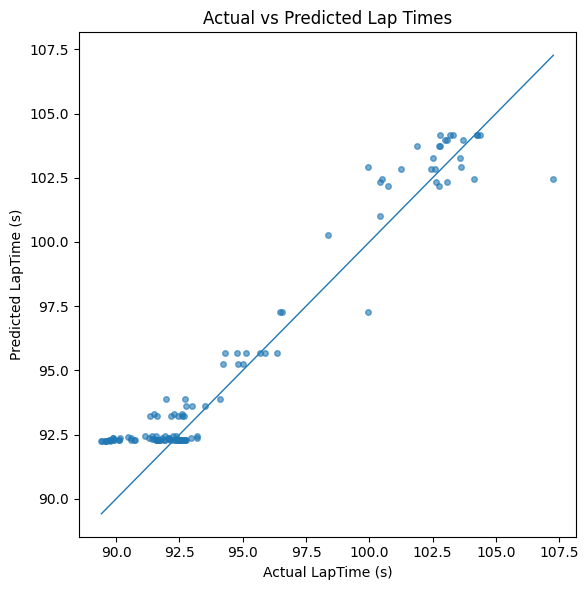

In [7]:

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, s=16)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linewidth=1)
plt.xlabel("Actual LapTime (s)")
plt.ylabel("Predicted LapTime (s)")
plt.title("Actual vs Predicted Lap Times")
plt.tight_layout()
plt.show()


### ^Interpretation of Actual vs Predicted Lap Time Plot:

- The points lie close to the line of best fit, with only a few outliers.

- Lower lap times (~90–95s) and higher lap times (~100–105s) are predicted with similar accuracy.

- A few scattered misses around 97–100s could correspond to traffic, partial tyre warm-up, or slow-inlaps that weren’t perfectly filtered.

- Takeaway: The model is well-calibrated across the lap time range.


### Permutation importance (global)
Which features drive the model most? (Robust to scaling/encoding choice.)


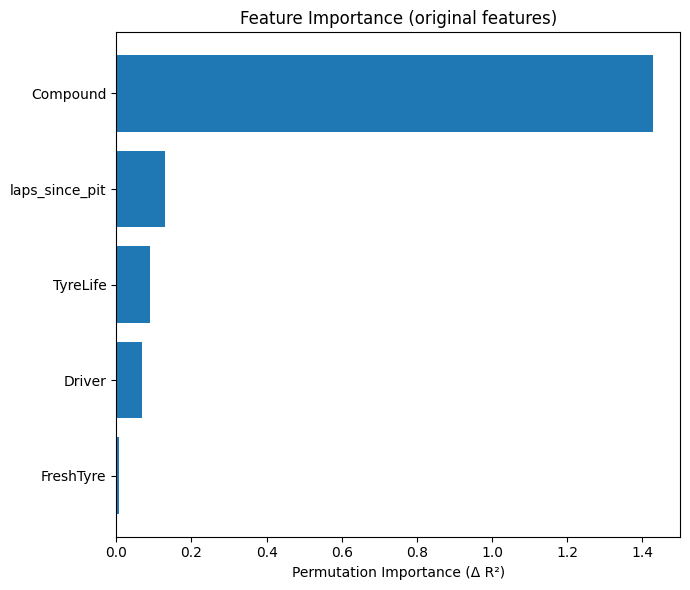

FreshTyre         0.006736
Driver            0.069439
TyreLife          0.089414
laps_since_pit    0.128619
Compound          1.429068
dtype: float64

In [8]:
# Refit on all data
pipe.fit(X, y)

# Permutation importance on the PIPELINE = one score per ORIGINAL column in X
idx = np.random.default_rng(0).choice(len(X), size=min(1000, len(X)), replace=False)
result = permutation_importance(pipe, X.iloc[idx], y[idx], n_repeats=5, random_state=0)

# Names must match ORIGINAL columns (not one-hot expanded)
feature_names = available_num + available_cat

importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(7,6))
plt.barh(importances.index, importances.values)
plt.xlabel("Permutation Importance (Δ R²)")
plt.title("Feature Importance (original features)")
plt.tight_layout()
plt.show()

importances.tail(10)


### ^Interpretation of Permutation Importance Plot:

- Tyre compound dominates (by far) — makes sense: switching from Soft → Medium → Hard explains most lap time differences in a race.

- laps_since_pit > TyreLife: the stint progression (proxy for fuel burn-off + tyre degradation) is slightly more predictive than raw tyre life. Good domain insight — not all tyre laps degrade equally depending on stint length.

- Driver has minor but non-zero importance: reflects car/driver pace differences, but since GroupKFold was by driver, we avoid overfitting.

- FreshTyre is almost irrelevant — because once compound is known, the model already captures the “outlap vs push lap” effect.

- Takeaway: Compound choice + stint phase explain most of the lap time variance in the race.


## 7) Tyre degradation quick‑look
A simple exploratory view: lap time vs **tyre life** by **compound**.  
This also doubles as a sanity check on our features.


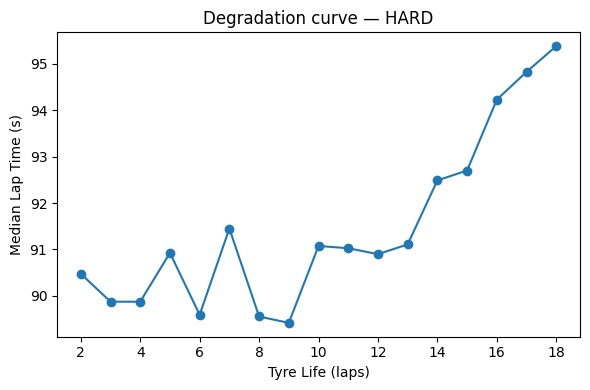

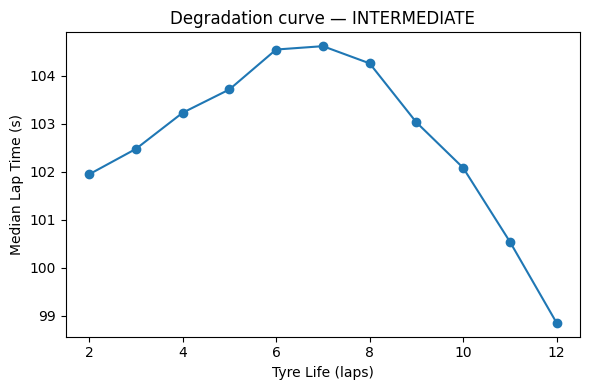

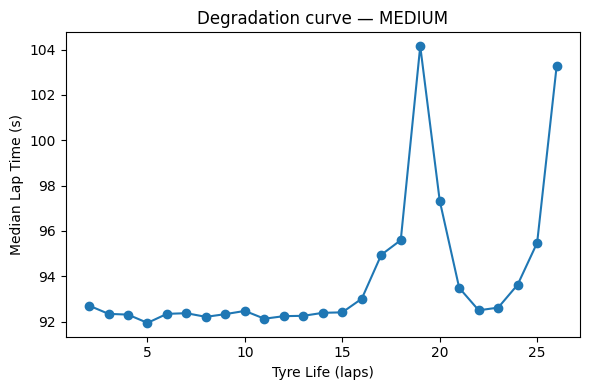

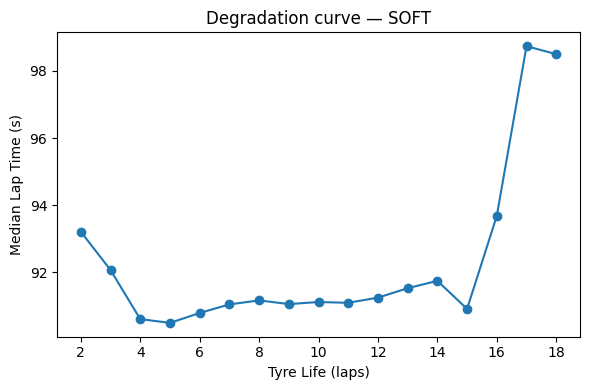

In [9]:

# Aggregate per (Compound, TyreLife)
agg = df_model.groupby(["Compound", "TyreLife"], as_index=False)["LapTime_s"].median()

# Plot one figure per compound for readability
for comp, grp in agg.groupby("Compound"):
    plt.figure(figsize=(6,4))
    plt.plot(grp["TyreLife"], grp["LapTime_s"], marker="o", linestyle="-")
    plt.xlabel("Tyre Life (laps)")
    plt.ylabel("Median Lap Time (s)")
    plt.title(f"Degradation curve — {comp}")
    plt.tight_layout()
    plt.show()



## 8) (Bonus) Push‑lap classifier
Define **push laps** as laps faster than a z‑score threshold within each driver. Train a simple classifier to detect push laps from stint/tyre context.


In [10]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

dfc = df_model.copy()
# Z-score per driver to remove driver baseline
dfc["z"] = dfc.groupby("Driver")["LapTime_s"].transform(lambda s: (s - s.mean()) / (s.std(ddof=0) + 1e-6))
dfc["is_push"] = (dfc["z"] <= -0.7).astype(int)  # faster (lower time) than ~0.7 sigma

Xc = dfc[available_num + available_cat]
yc = dfc["is_push"].values
groups_c = dfc["Driver"].values

pre_c = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), available_num),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), available_cat)
    ]
)

clf = Pipeline([("pre", pre_c), ("lr", LogisticRegression(max_iter=200))])

# Hold out drivers as before
drivers_c = np.array(sorted(dfc["Driver"].unique()))
rng = np.random.default_rng(123)
test_drivers_c = set(rng.choice(drivers_c, size=max(1, len(drivers_c)//5), replace=False))

mask = dfc["Driver"].isin(test_drivers_c)
clf.fit(Xc[~mask], yc[~mask])
yp = clf.predict(Xc[mask])

print(f"Test drivers held out: {sorted(test_drivers_c)}")
print(classification_report(yc[mask], yp, digits=3))


Test drivers held out: [np.str_('ALB'), np.str_('RIC'), np.str_('RUS')]
              precision    recall  f1-score   support

           0      0.856     0.969     0.909        98
           1      0.727     0.333     0.457        24

    accuracy                          0.844       122
   macro avg      0.792     0.651     0.683       122
weighted avg      0.831     0.844     0.820       122




## 9) Wrap‑up & next steps
**The project demonstrates**:
- Clean data ingestion from FastF1 with caching  
- Sensible filtering for modelling stability  
- Leakage‑aware validation by driver  
- Regression model for lap time + diagnostics + feature importance  
- A short tyre‑degradation analysis  
- Bonus classifier for identifying push laps

**Ideas for v2:**
- Add telemetry‑derived features (min/avg speed per sector, throttle/brake duty, gear change counts) for a single driver/session subset.
- Model sector times separately; add weather data.
- Add SHAP for local explainability; hyper‑parameter tuning with Optuna.
- Turn this into a Streamlit app to select any race/session interactively.
